In [1]:
## Group Members: Jason Hipkins, Naman Mital
import folium
import requests
import pandas as pd

arrest_table = pd.read_csv("http://www.hcbravo.org/IntroDataSci/misc/BPD_Arrests.csv")

arrest_table["race_new"] = arrest_table["sex"]
arrest_table["sex_new"] = arrest_table["race"]
arrest_table["race"] = arrest_table["race_new"]
arrest_table["sex"] = arrest_table["sex_new"]
arrest_table = arrest_table.drop('race_new', 1)
arrest_table = arrest_table.drop('sex_new', 1)

arrest_table = arrest_table[pd.notnull(arrest_table["Location 1"])]

arrest_table["lat"], arrest_table["long"] = arrest_table["Location 1"].str.split(",").str
arrest_table["lat"] = arrest_table["lat"].str.replace("(", "").astype(float)
arrest_table["long"] = arrest_table["long"].str.replace(")", "").astype(float)



## THIS IS REALLY IMPORTANT, you didnt drop all the NA
arrest_table = arrest_table.dropna()
#arrest_table
#arrest_table.count()

In [2]:
import seaborn as sns
western  = arrest_table[arrest_table.district == "WESTERN"]
arrest_table['arrestTime'] = pd.to_datetime(arrest_table['arrestTime']).dt.time
hour = []
for x in arrest_table['arrestTime']:
        hour.append(x.hour)
        
arrest_table['hour'] = pd.Series(hour).values

sns.distplot(arrest_table['hour'], bins = 24)

c:\users\jasonhipkins\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


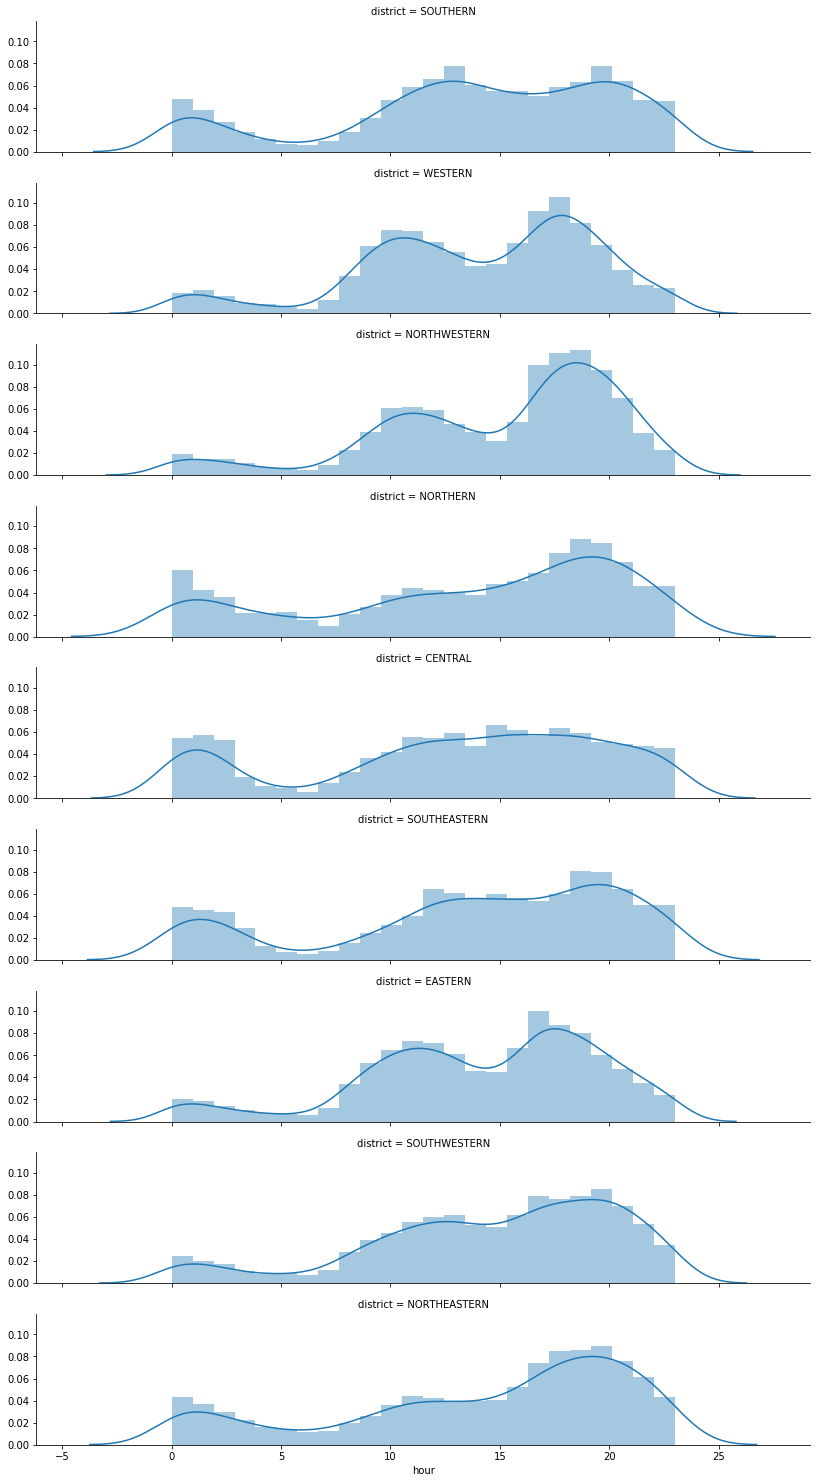

In [3]:
 
g = sns.FacetGrid(arrest_table, row="district",
                  height=2.3, aspect=5,)
g.map(sns.distplot, "hour", hist=True, bins = 24);

In [4]:
tot_crime_district = arrest_table['district'].value_counts()
dat = tot_crime_district.sort_index(ascending = True)
#dat

In [5]:
import requests
import json
from area import area

#district_geo = requests.get("https://opendata.arcgis.com/datasets/854179bc4e8844e9b444efce18a055a6_0.geojson")
#data = pd.read_csv("https://opendata.arcgis.com/datasets/854179bc4e8844e9b444efce18a055a6_0.csv")

with open('Police_Districts.geojson') as f:
    geo_data = json.load(f)

data = pd.read_csv("Police_Districts.csv")
dat1 = data.sort_values(by=['Dist_Name'])
dat1['Crimes'] =  dat.values
list = []

for x in geo_data['features']:
    list.append(area(x['geometry']))
    
area = pd.Series(list)
dat1 = dat1.sort_index()

dat1['area m^2'] = area
dat1['area km^2'] = dat1['area m^2'] * .000001
dat1['crime density km^2'] = dat1['Crimes']/dat1['area km^2']
dat1['crime density m^2'] = dat1['Crimes']/dat1['area m^2']
dat1

,OBJECTID,District,Dist_Name,Crimes,area m^2,area km^2,crime density km^2,crime density m^2
0,1,1,Central,6511,6.797932e+06,6.797932,957.791316,0.000958
1,2,2,Southeastern,5083,2.416325e+07,24.163246,210.360807,0.000210
2,3,3,Eastern,7135,9.692960e+06,9.692960,736.101237,0.000736
3,4,4,Northeastern,6141,4.151794e+07,41.517938,147.911969,0.000148
4,5,5,Northern,2816,3.505822e+07,35.058215,80.323541,0.000080
5,6,6,Northwestern,6593,2.519996e+07,25.199960,261.627398,0.000262
6,7,7,Western,8011,7.291207e+06,7.291207,1098.720745,0.001099
7,8,8,Southwestern,5376,2.656158e+07,26.561577,202.397621,0.000202
8,9,9,Southern,6374,3.480354e+07,34.803543,183.142276,0.000183


In [6]:
map_osm = folium.Map(location=[39.29, -76.61], zoom_start=11)


map_osm.choropleth(
    geo_data= geo_data,
    name='choropleth',
    data=dat1,
    columns=['Dist_Name', 'Crimes'],
    key_on='feature.properties.Dist_Name',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Crimes',
    highlight = True
)

folium.LayerControl().add_to(map_osm)

map_osm

c:\users\jasonhipkins\appdata\local\programs\python\python37-32\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [7]:
map = folium.Map(location=[39.29, -76.61], zoom_start=11)

map.choropleth(
    geo_data= geo_data,
    name='choropleth',
    data=dat1,
    columns=['Dist_Name', 'crime density km^2'],
    key_on='feature.properties.Dist_Name',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Crime Density km^2',
    highlight = True
)

folium.LayerControl().add_to(map)

map

#### In my maps and graphs I am attempting to show crime density in space and time. By using geojson GIS data from OpenGIS 
#### I was able to create a chloropleth map to show how many crimes are committed per police district, and then how many crimes committed per
#### km^2. I also attempted to find the modality of crime committed throughout the day and found that overall most crime is committed b/w 
#### 10am and 12pm and then 8pm to 2am. The areas with the highest crime density followed this modality to an extreme (the Western district)
#### but the central district seems to have consistent crime all day long. 